In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng
rng = default_rng()
import pandas as pd

In [5]:
#initialisation 

def psi(sample_G, mu, T, sigma, S0, mat_L, K) :  
    ST = S0[:,None] * np.exp(mu[:,None] * T + sigma[:,np.newaxis] * np.sqrt(T) * mat_L @ sample_G) #on transforme S0 et mu en colonne + multiplication matricielle 
    g = np.mean(ST,axis=0 )  #renvoie la moyenne de chaque vecteur colonne 
    return np.maximum( g-K , 0)

In [6]:
def monte_carlo (sample, proba=0.95) : 
    mean = np.mean(sample) 
    var = np.var ( sample , ddof = 1) 
    alpha = 1-proba 
    quantile_alpha = stats.norm.ppf (1- alpha/2 ) 
    intervalle_size = quantile_alpha * np.sqrt(var / sample.size) 
    return (mean, var , mean-intervalle_size, mean+intervalle_size) 

## monte carlo classique avec d=10, n=$10^5$ et $K \in [80,120]$ 


In [7]:
#initialisation: 

d = 10
T = 1
r = 0.01
S0 = np.full(d, 100)
sigma = np.arange(1,d+1)/(2*d)
mu = r - 0.5*sigma**2
rho = 0.2
correl = np.full((d,d), rho) + (1-rho)*np.eye(d) #matrice avec des rho + matrice avec (1-rho) sur la diagonale  
mat_L = np.linalg.cholesky(correl)
n = int(1e5)

Strike = [80,90,100,110,120]

sample_G_mc = rng.standard_normal(size=(d, n))

MC = [ monte_carlo(psi(sample_G_mc, mu, T, sigma, S0, mat_L, k), 0.95) for k in Strike ]

df_mc = pd.DataFrame(MC, columns=['mean', 'var', 'lower', 'upper'], index= Strike)
df_mc

,mean,var,lower,upper
80,21.310103,227.482150,21.216622,21.403584
90,12.769579,180.819491,12.686236,12.852923
100,6.580384,111.565281,6.514918,6.645849
110,2.952312,54.692688,2.906475,2.998148
120,1.198255,22.792026,1.168666,1.227845


## Comparaison des méthodes de simulations 

1. Variables antithétiques 

In [7]:
V_A = [monte_carlo(0.5 * (psi(sample_G_mc, mu, T, sigma, S0, mat_L, k) + psi(-sample_G_mc, mu, T, sigma, S0, mat_L, k)),0.95) for k in Strike]

df_antith = pd.DataFrame(V_A, columns=['mean', 'var', 'lower', 'upper'], index=Strike)
df_antith


,mean,var,lower,upper
80,21.300106,14.234501,21.276722,21.323490
90,12.770240,25.927009,12.738681,12.801799
100,6.583718,34.145360,6.547501,6.619935
110,2.962458,22.752460,2.932894,2.992022
120,1.196541,10.469784,1.176486,1.216595


2. Variable de Contrôle : cas de la dimension 1 

In [8]:
def price_call_BS(x, r, sigma, T, K):
    d1 = (np.log(x / K) + T * (r + 0.5*sigma**2)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return x * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

In [9]:
barS0 = S0.mean()
a = S0 / S0.sum()
m = (a * (r - 0.5*sigma**2)).sum()
s2 = (((a * sigma).T @ mat_L)**2).sum()  #.T >> transposée 
rho_controle = m + 0.5*s2


In [10]:
Liste_controle = []
for j in Strike:
    Z = np.sum(a[:,None] * (m*T + sigma[:,None]*np.sqrt(T)*mat_L@sample_G_mc), axis = 0)
    Y = np.maximum(S0.mean() * np.exp(Z) - j, 0)
    Y_mean = np.exp(rho_controle*T) * price_call_BS(barS0, rho_controle, np.sqrt(s2), T, j)
    control_variate = Y - Y_mean
    sample_controle = psi(sample_G_mc, mu, T, sigma, S0, mat_L, j ) - control_variate
    Liste_controle.append(monte_carlo(sample_controle))

df_controle = pd.DataFrame(Liste_controle, columns=['mean', 'var', 'lower', 'upper'], index=Strike)
df_controle


,mean,var,lower,upper
80,21.309473,6.371149,21.293829,21.325117
90,12.785392,7.559568,12.768350,12.802433
100,6.599707,7.839931,6.582353,6.617061
110,2.972963,6.496278,2.957166,2.988761
120,1.201025,4.306966,1.188162,1.213887


3. Variable de Controle optimale 

In [12]:
Liste_controle_opt = []

for j in Strike:
    Z = np.sum(a[:,None] * (m*T + sigma[:,None]*np.sqrt(T)*mat_L@sample_G_mc), axis = 0)
    Y = np.maximum(S0.mean() * np.exp(Z) - j, 0)
    Y_mean = np.exp(rho_controle*T) * price_call_BS(barS0, rho_controle, np.sqrt(s2), T, j)
    
    Y_centrée = Y - Y_mean
    Lambda = np.mean(psi(sample_G_mc, mu, T, sigma, S0, mat_L, j ) * Y_centrée ) / np.mean(Y_centrée**2) 
    sample_optimal = psi(sample_G_mc, mu, T, sigma, S0, mat_L, j ) - (Lambda * Y_centrée)  
   
    Liste_controle_opt.append(monte_carlo(sample_optimal))
    
df_controle_opt = pd.DataFrame(Liste_controle_opt, columns=['mean', 'var', 'lower', 'upper'], index=Strike)
df_controle_opt


,mean,var,lower,upper
80,21.303540,5.255632,21.289331,21.317749
90,12.778462,5.136928,12.764414,12.792509
100,6.594950,4.525903,6.581764,6.608135
110,2.972454,3.531307,2.960807,2.984101
120,1.203770,2.388951,1.194190,1.213350


4. Comparaison

Text(0.5, 1.0, 'Ratio de variances en fonction du Strike')

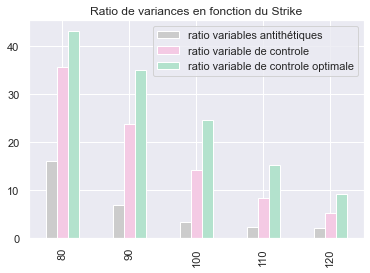

In [34]:
ratio_antith = df_mc["var"] / df_antith["var"]
ratio_controle = df_mc["var"] / df_controle["var"]
ratio_controle_optimal = df_mc["var"] / df_controle_opt ["var"]

A = ratio_antith.to_list()
C = ratio_controle.to_list()
C_O = ratio_controle_optimal.to_list()

df_ratio = pd.DataFrame(A, columns=["ratio variables antithétiques"], index= Strike)
df_ratio["ratio variable de controle"] = C #je rajoute une colonne 
df_ratio["ratio variable de controle optimale"] = C_O

df_ratio.plot.bar(colormap='Pastel2_r')  #data frame visualisé directement avec des barres 
plt.title('Ratio de variances en fonction du Strike')

#la méthode de la variable de controle optimale est meilleure pour toutes les valeurs de K choisies 

## Influence de K 
  

In [8]:
n = int(1e5)
sample_G_K = rng.standard_normal(size=(d, n))
Ks = list(range(30,165,5))
Liste_K = [ monte_carlo(psi(sample_G_K, mu, T, sigma, S0, mat_L, k), 0.95) for k in Ks ]


df_K = pd.DataFrame(Liste_K, columns=['mean', 'var', 'lower', 'upper'], index=Ks)
df_K


,mean,var,lower,upper
30,71.041409,242.704553,70.944851,71.137966
35,66.041409,242.704553,65.944851,66.137966
40,61.041409,242.704553,60.944851,61.137966
45,56.041409,242.704553,55.944851,56.137966
50,51.041409,242.704553,50.944851,51.137966
55,46.041409,242.704553,45.944851,46.137966
60,41.041685,242.680910,40.945132,41.138238
65,36.043783,242.522674,35.947262,36.140305
70,31.058916,241.528760,30.962592,31.155239
75,26.125352,237.799210,26.029775,26.220929


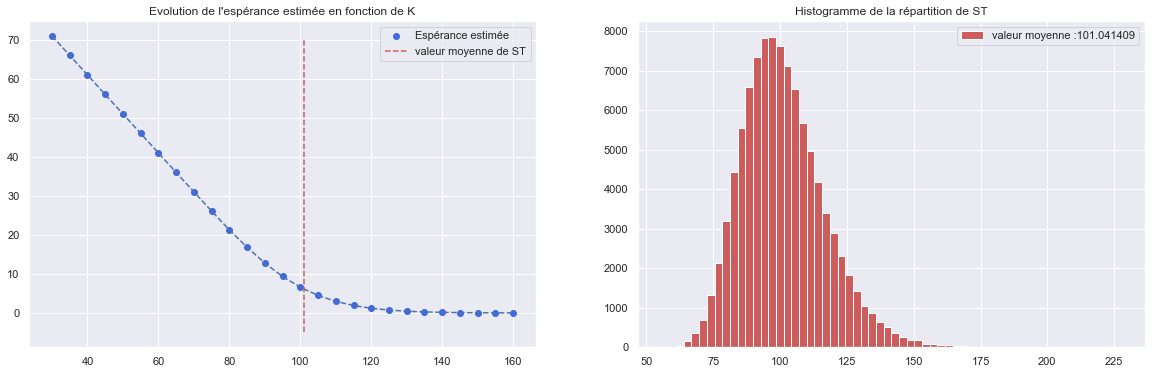

In [164]:
fig, (ax1, ax2) = plt.subplots( nrows= 1 , ncols = 2 , figsize = (20, 6)) 

ST = S0[:,None] * np.exp(mu[:,None] * T + sigma[:,np.newaxis] * np.sqrt(T) * mat_L @ sample_G_K) 
g = np.mean(ST,axis=0 )
ax2.hist(g, bins=60, label =f'valeur moyenne :{np.mean(g):f}', color='indianred')
ax2.set_title ("Histogramme de la répartition de ST")
ax2.legend()

ax1.scatter (Ks , df_K['mean'], label ='Espérance estimée', color='royalblue')
ax1.plot( Ks,df_K['mean'], '--')
ax1.vlines(np.mean(g), ymin=-5, ymax=70,linestyle='--', color='indianred', label='valeur moyenne de ST')

ax1.set_title ("Evolution de l'espérance estimée en fonction de K")
ax1.legend()



#valeur limite K=102: la qtt (St-K) devient négative 

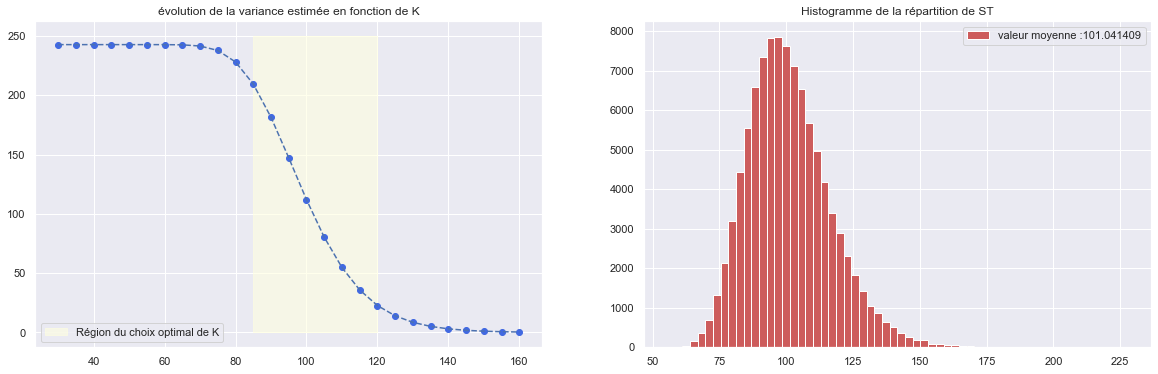

In [168]:
fig, (ax1, ax2) = plt.subplots( nrows= 1 , ncols = 2 , figsize = (20, 6)) 

ax1.fill_between( Ks[11:19] , 0, 250, color = 'lightyellow', alpha = 0.6, label='Région du choix optimal de K')
ax1.scatter (Ks , df_K['var'], color='royalblue')
ax1.plot (Ks , df_K['var'],'--')
ax1.set_title ("évolution de la variance estimée en fonction de K")
ax1.legend(loc='lower left')



ax2.hist(g, bins=60, label =f'valeur moyenne :{np.mean(g):f}', color='indianred')
ax2.set_title ("Histogramme de la répartition de ST")
ax2.legend()

#sns.regplot(df_K)

## influence du nombre d'echantillon n 

In [130]:
K = 80
N = [2**m for m in range (10,25)]

sample_G_N = [rng.standard_normal(size=(d,n)) for n in N]
Liste_N=[monte_carlo(psi(s, mu, T, sigma, S0, mat_L, K), 0.95) for s in sample_G_N ]


df_N = pd.DataFrame(Liste_N, columns=['mean', 'var', 'lower', 'upper'], index=N)
df_N


,mean,var,lower,upper
1024,20.670339,219.185240,19.763556,21.577123
2048,22.036853,234.778874,21.373243,22.700462
4096,21.638525,227.975112,21.176131,22.100918
8192,21.446255,231.725912,21.116615,21.775896
16384,21.241636,227.078314,21.010895,21.472378
32768,21.279224,230.248968,21.114929,21.443518
65536,21.266206,226.476090,21.150988,21.381424
131072,21.228949,226.908129,21.147400,21.310498
262144,21.331712,228.464865,21.273850,21.389573
524288,21.286895,227.231393,21.246091,21.327698


Text(0.5, 1.0, 'Evolution de la variance estimée en fonction de n')

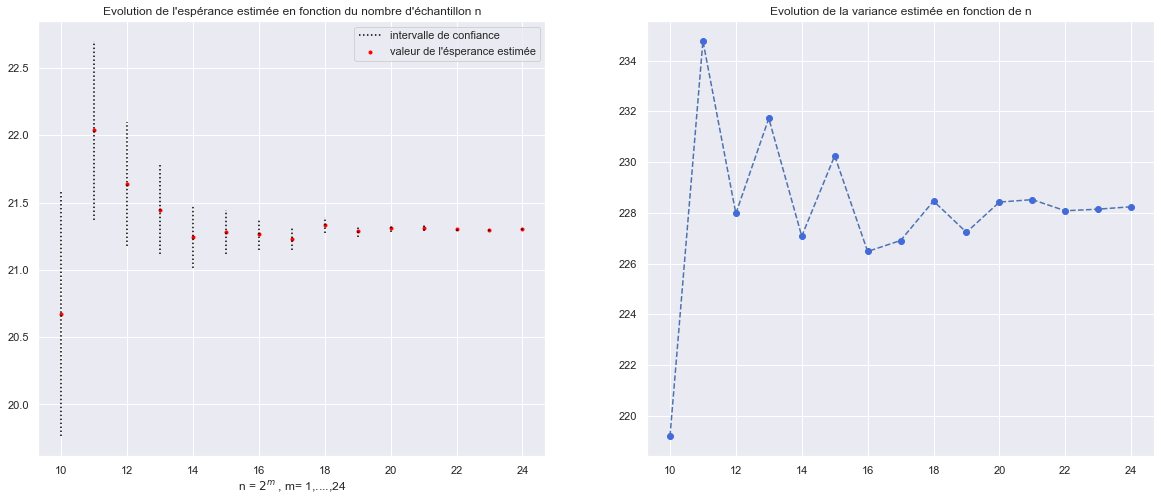

In [170]:
fig, (ax1, ax2) = plt.subplots( nrows= 1 , ncols = 2 , figsize = (20, 8)) 
abscisse =list(range(10,25,1))
valeurs  = df_N.to_numpy()

ax1.vlines (abscisse, valeurs[:,2], valeurs[:,3], linestyles='dotted', color='black', label='intervalle de confiance')
ax1.scatter (abscisse , df_N['mean'], marker='.', color='red', label="valeur de l'ésperance estimée")
ax1.set_title ("Evolution de l'espérance estimée en fonction du nombre d'échantillon n")
ax1.legend()
ax1.set_xlabel ( 'n = $2^m$ , m= 1,....,24')


ax2.scatter (abscisse , df_N['var'], color='royalblue')
ax2.plot (abscisse , df_N['var'],'--')
ax2.set_title ("Evolution de la variance estimée en fonction de n")
 
 

## Influence de la dimension d 

In [32]:
D = list(range(10,500,50)) 

rho = 0.2
T = 1
K = 80
n = int(1e5)
Liste_D = []

for dimension in D : 

    r = 0.01
    S0_D = np.full(dimension, 100)
    sigma_D = np.arange(1,dimension+1)/(2*dimension)
    mu_D = r - 0.5*sigma_D**2

    correl_D = np.full((dimension,dimension), rho) + (1-rho)*np.eye(dimension) #matrice avec des rho + matrice avec (1-rho) sur la diagonale  
    mat_L_D = np.linalg.cholesky(correl_D)

    sample_G_D = rng.standard_normal(size=(dimension, n)) 
 
    resultat = monte_carlo(psi(sample_G_D, mu_D, T, sigma_D, S0_D, mat_L_D, K))
    Liste_D.append(resultat) 

df_D = pd.DataFrame(Liste_D, columns=['mean', 'var', 'lower', 'upper'], index = D )
df_D
    



,mean,var,lower,upper
10,21.279037,229.712753,21.185100,21.372975
60,21.105954,141.977385,21.032103,21.179806
110,21.091084,135.403814,21.018963,21.163205
160,21.119941,132.401824,21.048623,21.191258
210,21.088407,131.844780,21.017240,21.159574
260,21.031877,129.470306,20.961353,21.102400
310,21.010546,129.080208,20.940129,21.080963
360,21.041664,129.746679,20.971065,21.112262
410,21.047046,128.208547,20.976867,21.117225
460,20.999835,127.434610,20.929868,21.069802


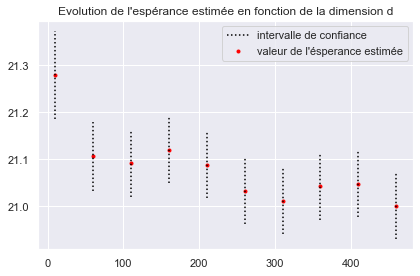

In [33]:
fig, ax = plt.subplots(layout="tight")
xx_D = list(range(10,500,50))
valeurs_D  = df_D.to_numpy()
ax.vlines (xx_D, valeurs_D[:,2], valeurs_D[:,3], linestyles='dotted', color='black', label='intervalle de confiance')
ax.scatter (xx_D , df_D['mean'], marker='.', color='red', label="valeur de l'ésperance estimée")
ax.set_title ("Evolution de l'espérance estimée en fonction de la dimension d")
ax.legend()

#pd.plot.bar(yerr= errors) 

Text(0.5, 1.0, 'Evolution de la variance estimée en fonction de la dimension d')

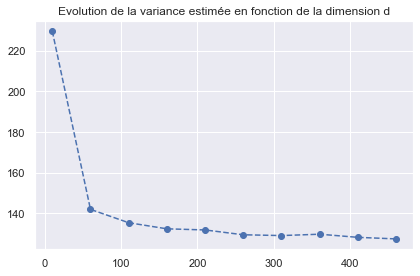

In [34]:
fig, ax = plt.subplots(layout="tight")
ax.scatter (xx_D , df_D['var'])
ax.plot (xx_D , df_D['var'],'--')
ax.set_title ("Evolution de la variance estimée en fonction de la dimension d")